<a href="https://colab.research.google.com/github/Shalu31/30-days--30-project-in-AI/blob/main/BrainTumourclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Name**- **Brain Tumor Classification**

Contribution - Individual
Name - Shalu Verma

**GITHUB LINK** -- https://github.com/Shalu31/Brain_tumor_classification.git

**Problem Statement**
This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.

**Let's Begin**
**1.Know Your Data**

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datadir = '/content/drive/MyDrive/Tumour'

In [ ]:
categories = ['glioma','meningioma','no_tumor','pituitary']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm


<Figure size 2000x1000 with 0 Axes>

IndexError: list index out of range

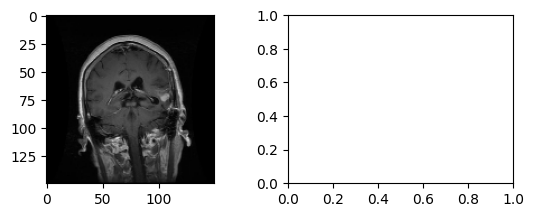

In [ ]:
plt.figure(figsize=(20,10))
images_path = ['/content/drive/MyDrive/Tumour/test/glioma/Tr-gl_0016_jpg.rf.99746694ea97fe0b73108832b462d48e.jpg']
plt.show()
for i in range(4):
  plt.subplot(2,2,i+1)
  img = cv2.imread(images_path[i])
  img = cv2.resize(img,(150,150))
  plt.imshow(img)

In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torchvision

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from torchvision import datasets, transforms

data_dir = '/content/drive/MyDrive/Tumour'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder(test_dir, transform=transforms.ToTensor())
val_dataset = datasets.ImageFolder(val_dir, transform=transforms.ToTensor())
print("Train:", len(train_dataset))

Train: 1695


The dataset consists of brain MRI images divided into 3 folders: train, valid, and test. Each folder has 4 subfolders representing tumor classes: glioma, meningioma, pituitary, and no_tumor. The dataset is well-organized for supervised classification.

In [ ]:
print("Tumor Classes:", train_dataset.classes)
print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))
print("Test images:", len(test_dataset))

Tumor Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Train images: 1695
Val images: 502
Test images: 246


Total Images: XYZ

Total Classes: 4

Rows represent the total number of labeled images. Columns represent the class categories.



In [ ]:
total_images = len(train_dataset) + len(val_dataset) + len(test_dataset)
n_classes = len(train_dataset.classes)

print("Total images:", total_images)
print("Total classes:", n_classes)

Total images: 2443
Total classes: 4


Dataset Information
Each image is an RGB image resized to 224x224 for model compatibility. Images are normalized and loaded using PyTorch's ImageFolder. The label is assigned based on folder name and internally mapped to class indices.

In [ ]:
IMG_SIZE = 224

# ImageNet stats (used even if not pretrained to maintain good normalization)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [ ]:
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

What did you know about your dataset?
The dataset contains brain MRI scans categorized into four tumor types: glioma, meningioma, pituitary tumor, and no tumor. The images are RGB and show consistent structure. The dataset is pre-split into train, validation, and test sets with minimal class imbalance. It is suitable for deep learning tasks, and can be used effectively with both custom CNNs and pretrained models after appropriate resizing and normalization.

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transform)

classes = train_dataset.classes
print("Classes:", classes)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Train samples: 1695
Validation samples: 502
Test samples: 246


**Transforms for Each Set**

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [ ]:
import torch.nn as nn

class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# Instantiate
num_classes = len(classes)
model = BrainTumorCNN(num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

**Defining the training loop**

In [ ]:
from tqdm import tqdm
import time # Import time module

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(epochs):
        start = time.time()

        model.train()
        running_loss = 0
        correct = 0
        total = 0

        print(f"\n🟢 Epoch {epoch + 1}/{epochs} [Training]")
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_loss_list.append(avg_train_loss)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        print(f"🔵 Epoch {epoch + 1}/{epochs} [Validation]")
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(val_accuracy)

        end = time.time()
        print(f"✅ Epoch [{epoch+1}/{epochs}] | ⏱ Time: {end-start:.1f}s | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    return train_loss_list, val_loss_list, val_acc_list


In [ ]:
EPOCHS = 10  # you can increase this later

train_losses, val_losses, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS
)



🟢 Epoch 1/10 [Training]


🔵 Epoch 1/10 [Validation]


✅ Epoch [1/10] | ⏱ Time: 717.3s | Train Loss: 1.4573 | Val Loss: 0.6832 | Val Acc: 74.50%

🟢 Epoch 2/10 [Training]


🔵 Epoch 2/10 [Validation]


✅ Epoch [2/10] | ⏱ Time: 30.5s | Train Loss: 0.7348 | Val Loss: 0.6982 | Val Acc: 69.92%

🟢 Epoch 3/10 [Training]


🔵 Epoch 3/10 [Validation]


✅ Epoch [3/10] | ⏱ Time: 30.9s | Train Loss: 0.6823 | Val Loss: 0.5927 | Val Acc: 77.89%

🟢 Epoch 4/10 [Training]


🔵 Epoch 4/10 [Validation]


✅ Epoch [4/10] | ⏱ Time: 30.6s | Train Loss: 0.6585 | Val Loss: 0.5293 | Val Acc: 78.29%

🟢 Epoch 5/10 [Training]


🔵 Epoch 5/10 [Validation]


✅ Epoch [5/10] | ⏱ Time: 31.0s | Train Loss: 0.6360 | Val Loss: 0.6067 | Val Acc: 78.49%

🟢 Epoch 6/10 [Training]


🔵 Epoch 6/10 [Validation]


✅ Epoch [6/10] | ⏱ Time: 31.5s | Train Loss: 0.5716 | Val Loss: 0.5158 | Val Acc: 79.88%

🟢 Epoch 7/10 [Training]


🔵 Epoch 7/10 [Validation]


✅ Epoch [7/10] | ⏱ Time: 30.5s | Train Loss: 0.5811 | Val Loss: 0.5899 | Val Acc: 78.49%

🟢 Epoch 8/10 [Training]


🔵 Epoch 8/10 [Validation]


✅ Epoch [8/10] | ⏱ Time: 31.0s | Train Loss: 0.5675 | Val Loss: 0.5670 | Val Acc: 80.08%

🟢 Epoch 9/10 [Training]


🔵 Epoch 9/10 [Validation]


✅ Epoch [9/10] | ⏱ Time: 30.9s | Train Loss: 0.5366 | Val Loss: 0.5435 | Val Acc: 80.28%

🟢 Epoch 10/10 [Training]


🔵 Epoch 10/10 [Validation]


✅ Epoch [10/10] | ⏱ Time: 30.7s | Train Loss: 0.5639 | Val Loss: 0.5769 | Val Acc: 78.29%


**Evaluation Report**

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"🎯 Test Accuracy: {acc:.2f}%")
    return acc


In [ ]:
test_accuracy = evaluate_model(model, test_loader)

🎯 Test Accuracy: 78.05%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def test_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\n📄 Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("🧠 Confusion Matrix")
    plt.show()



📄 Classification Report:

              precision    recall  f1-score   support

      glioma       0.73      0.91      0.81        80
  meningioma       0.68      0.54      0.60        63
    no_tumor       0.88      0.73      0.80        49
   pituitary       0.89      0.91      0.90        54

    accuracy                           0.78       246
   macro avg       0.79      0.77      0.78       246
weighted avg       0.78      0.78      0.77       246



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


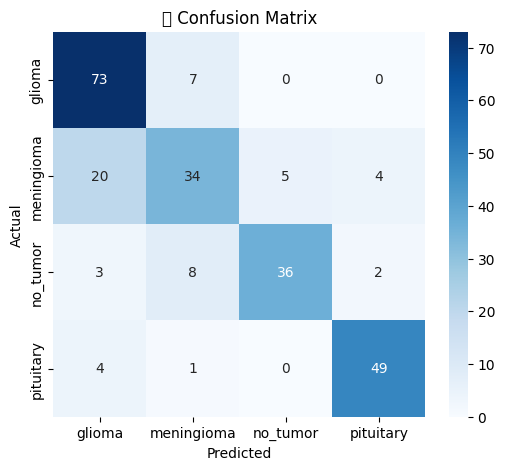

In [ ]:
test_metrics(model, test_loader, classes)

In [ ]:
def show_misclassified(model, test_loader, class_names, max_images=6):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), preds[i].cpu(), labels[i]))
                if len(misclassified) >= max_images:
                    break
        if not misclassified:
            print("🎉 No misclassified images!")
            return

    plt.figure(figsize=(12, 8))
    for i, (img, pred, true) in enumerate(misclassified[:6]):
        plt.subplot(2, 3, i + 1)
        img = img.permute(1, 2, 0) * torch.tensor(IMAGENET_STD) + torch.tensor(IMAGENET_MEAN)
        img = img.clamp(0, 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}")
        plt.axis('off')
    plt.suptitle("❌ Misclassified Images", fontsize=16)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-27-2923228662.py:28: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


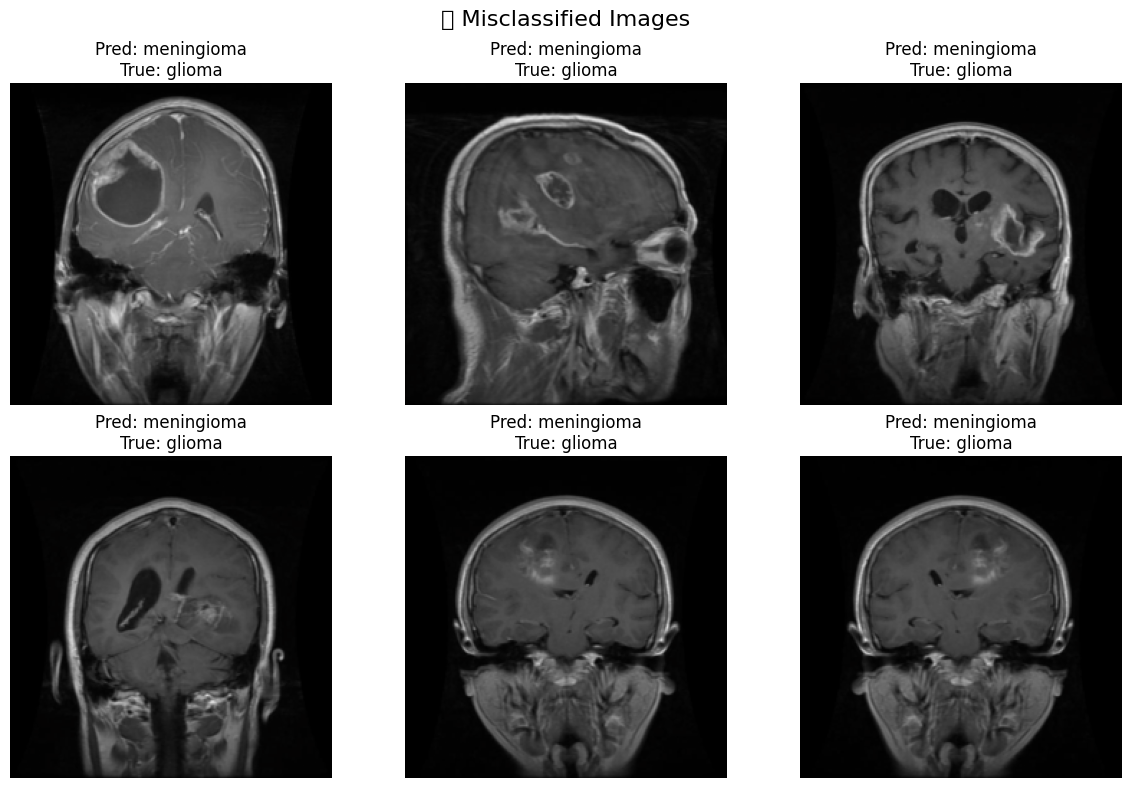

In [ ]:
show_misclassified(model, test_loader, classes)


In [ ]:
from torchviz import make_dot

dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)

make_dot(output, params=dict(list(model.named_parameters()))).render("cnn_model_graph", format="png")


ModuleNotFoundError: No module named 'torchviz'

In [ ]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 882.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

**Transfer Learning**

In [ ]:
from torchviz import make_dot

dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)

make_dot(output, params=dict(list(model.named_parameters()))).render("cnn_model_graph", format="png")



'cnn_model_graph.png'

**Fine tuning**

In [ ]:

from torchvision import models

resnet = models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace the classifier head
from torch import nn

num_classes = len(classes)  # e.g., 4 or 6

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

resnet = resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.2MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-4)


In [ ]:
train_losses, val_losses, val_accuracies = train_model(
    resnet, criterion, optimizer, train_loader, val_loader, epochs=3
)


🟢 Epoch 1/3 [Training]


🔵 Epoch 1/3 [Validation]


✅ Epoch [1/3] | ⏱ Time: 29.5s | Train Loss: 1.2433 | Val Loss: 1.1195 | Val Acc: 55.78%

🟢 Epoch 2/3 [Training]


🔵 Epoch 2/3 [Validation]


✅ Epoch [2/3] | ⏱ Time: 29.1s | Train Loss: 0.9518 | Val Loss: 0.8899 | Val Acc: 69.52%

🟢 Epoch 3/3 [Training]


🔵 Epoch 3/3 [Validation]


✅ Epoch [3/3] | ⏱ Time: 29.6s | Train Loss: 0.7935 | Val Loss: 0.7396 | Val Acc: 73.31%


In [ ]:
from torchvision import models

resnet = models.resnet18(pretrained=True)


in_features = resnet.fc.in_features

resnet.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
).to(device)

resnet = resnet.to(device)


# Unfreeze last few layers (layer4 block)
for name, param in resnet.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
finetune_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses, val_losses, val_accuracies = train_model(
    resnet, criterion, finetune_optimizer, train_loader, val_loader, epochs=10
)


🟢 Epoch 1/10 [Training]


🔵 Epoch 1/10 [Validation]


✅ Epoch [1/10] | ⏱ Time: 31.0s | Train Loss: 1.2916 | Val Loss: 1.2170 | Val Acc: 66.93%

🟢 Epoch 2/10 [Training]


🔵 Epoch 2/10 [Validation]


✅ Epoch [2/10] | ⏱ Time: 30.3s | Train Loss: 1.1015 | Val Loss: 1.0238 | Val Acc: 77.09%

🟢 Epoch 3/10 [Training]


🔵 Epoch 3/10 [Validation]


✅ Epoch [3/10] | ⏱ Time: 30.8s | Train Loss: 0.9412 | Val Loss: 0.8894 | Val Acc: 75.50%

🟢 Epoch 4/10 [Training]


🔵 Epoch 4/10 [Validation]


✅ Epoch [4/10] | ⏱ Time: 30.7s | Train Loss: 0.8159 | Val Loss: 0.7806 | Val Acc: 76.29%

🟢 Epoch 5/10 [Training]


🔵 Epoch 5/10 [Validation]


✅ Epoch [5/10] | ⏱ Time: 30.9s | Train Loss: 0.7050 | Val Loss: 0.6947 | Val Acc: 78.88%

🟢 Epoch 6/10 [Training]


🔵 Epoch 6/10 [Validation]


✅ Epoch [6/10] | ⏱ Time: 30.0s | Train Loss: 0.6303 | Val Loss: 0.6327 | Val Acc: 79.28%

🟢 Epoch 7/10 [Training]


🔵 Epoch 7/10 [Validation]


✅ Epoch [7/10] | ⏱ Time: 30.2s | Train Loss: 0.5601 | Val Loss: 0.5634 | Val Acc: 82.67%

🟢 Epoch 8/10 [Training]


🔵 Epoch 8/10 [Validation]


✅ Epoch [8/10] | ⏱ Time: 30.1s | Train Loss: 0.4999 | Val Loss: 0.5159 | Val Acc: 83.07%

🟢 Epoch 9/10 [Training]


🔵 Epoch 9/10 [Validation]


✅ Epoch [9/10] | ⏱ Time: 29.8s | Train Loss: 0.4551 | Val Loss: 0.4613 | Val Acc: 85.86%

🟢 Epoch 10/10 [Training]


🔵 Epoch 10/10 [Validation]


✅ Epoch [10/10] | ⏱ Time: 29.8s | Train Loss: 0.4158 | Val Loss: 0.4466 | Val Acc: 85.66%


In [ ]:
torch.save(resnet.state_dict(), 'resnet18_brain_tumor_best.pth')